# Problem Understanding

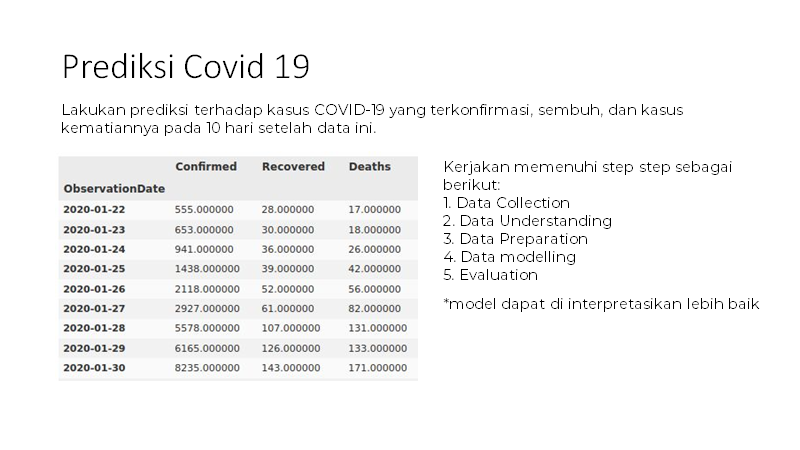

proses prediksi bisa dilakukan dengan berbagai pendekatan sesuai dengan problem, data dan kebutuhannya.

pada kasus ini akan dilakukan pendekatan prediksi menggunakan metode SIR.

# Indetify the data sources

data yang diterima berupa data dengan format CSV dengan ukuran 3 KB. sehingga proses penerimaan data dan memuat data hanya perlu akses download dan load file ke python pada umumnya

# Define Data

## Library

In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from datetime import timedelta, datetime

from sklearn.model_selection import RandomizedSearchCV , train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error


'export' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'E:\gitlab\custom-script\script')
from ursar import time_series,describe

%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reading data and preprocessing

In [4]:
# Load dataset
df = pd.read_csv(f'E:\gitlab\machine-learning\dataset\covid.csv',index_col='ObservationDate',parse_dates=True)

In [5]:
df

,day_of_year,Confirmed,Recovered,Deaths
ObservationDate,,,,
2020-01-22,22,555,28,17
2020-01-23,23,653,30,18
2020-01-24,24,941,36,26
2020-01-25,25,1438,39,42
2020-01-26,26,2118,52,56
...,...,...,...,...
2020-03-26,86,529591,122150,23970
2020-03-27,87,593291,130915,27198
2020-03-28,88,660706,139415,30652


## add 1 column as active case

In [127]:
df['Active'] = df['Confirmed'] - (df['Deaths'] + df['Recovered'])

In [128]:
df

,day_of_year,Confirmed,Recovered,Deaths,Active
ObservationDate,,,,,
2020-01-22,22,555,28,17,510
2020-01-23,23,653,30,18,605
2020-01-24,24,941,36,26,879
2020-01-25,25,1438,39,42,1357
2020-01-26,26,2118,52,56,2010
...,...,...,...,...,...
2020-03-26,86,529591,122150,23970,383471
2020-03-27,87,593291,130915,27198,435178
2020-03-28,88,660706,139415,30652,490639


## description data

In [129]:
describe.describe_data(df)

Dataframe has 5 columns.
There are 0 columns that have missing values.


,column_names,Data Type,Missing Values,% missing,low Value,Hi Value,unique
0,day_of_year,int64,0,0.0,22,90,69
1,Confirmed,int64,0,0.0,555,782365,69
2,Recovered,int64,0,0.0,28,164566,69
3,Deaths,int64,0,0.0,17,37582,69
4,Active,int64,0,0.0,510,580217,69


In [130]:
describe.profiling(df,"test",'test')

# Exploratory Data Analysis

## Visualization

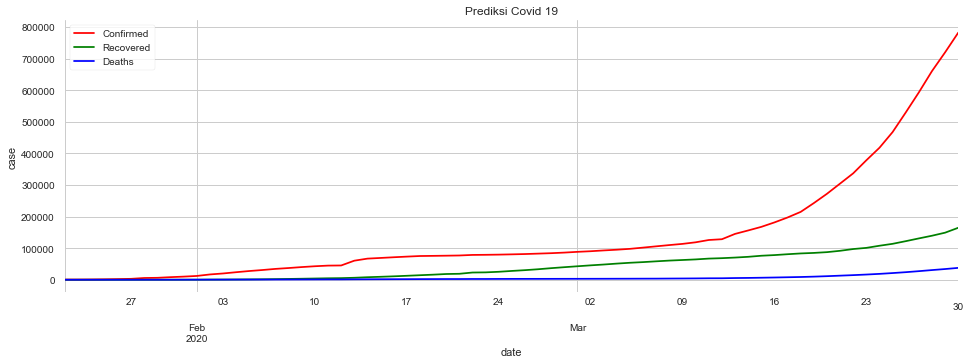

In [131]:
title='Prediksi Covid 19'
ylabel='case'
xlabel='date' 

ax = df['Confirmed'].plot(figsize=(16,5),color='red',title=title,LABEL='Confirmed')
df['Recovered'].plot(figsize=(16,5),color='green',title=title,LABEL='Recovered')
df['Deaths'].plot(figsize=(16,5),color='blue',title=title,LABEL='Deaths')
ax.autoscale(axis='x',tight=True)
ax.grid(True)
ax.legend()
ax.set(xlabel=xlabel, ylabel=ylabel)
plt.show()

Cara yang lebih ilmiah untuk melihat data ini adalah dengan melihatnya pada skala Semi-Log. Ini dapat dicapai dengan perubahan kecil dalam pengaturan sumbu y (type = "log"). 

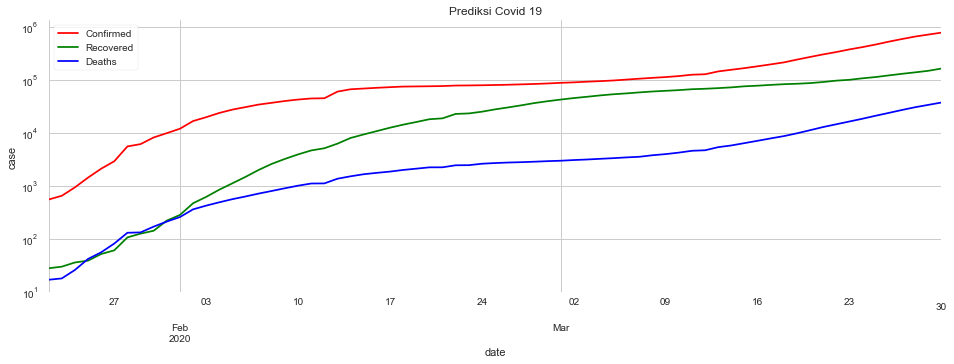

In [132]:
title='Prediksi Covid 19'
ylabel='case'
xlabel='date' 

ax = df['Confirmed'].plot(figsize=(16,5),color='red',title=title,LABEL='Confirmed')
df['Recovered'].plot(figsize=(16,5),color='green',title=title,LABEL='Recovered')
df['Deaths'].plot(figsize=(16,5),color='blue',title=title,LABEL='Deaths')
ax.autoscale(axis='x',tight=True)
ax.grid(True)
ax.legend()
ax.set_yscale("log")
ax.set(xlabel=xlabel, ylabel=ylabel)
plt.show()

pada data didapat peningkatan secara eksponensial, yang akan mengarah pada model khusus yang dapat menangani prediksi data eksponen

## ETS decomposition of data

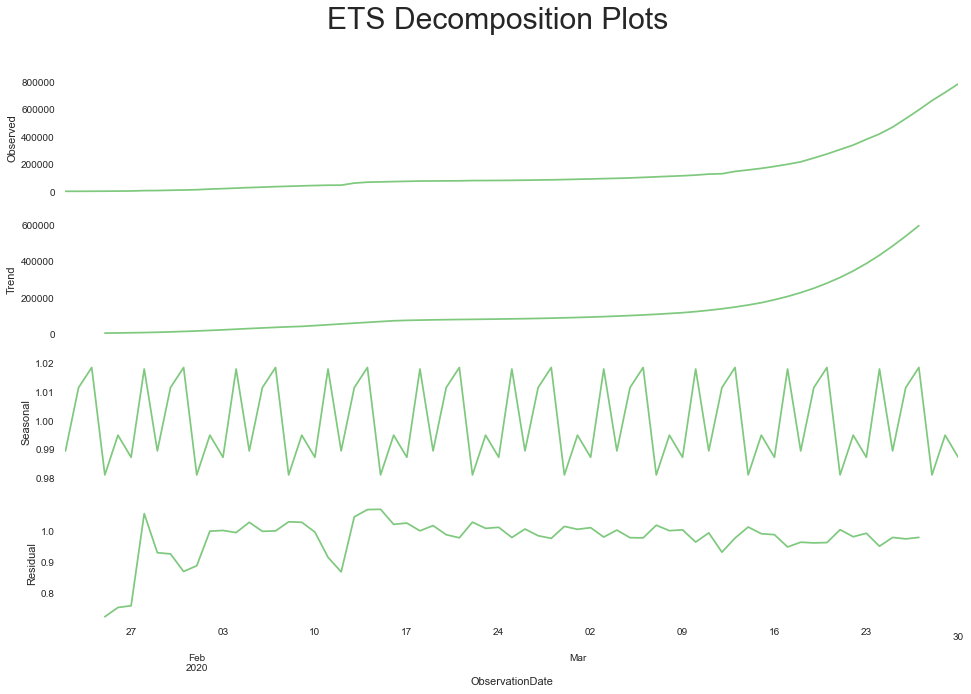

In [10]:
time_series.decomposition_plot(df,'Confirmed','multiplicative')

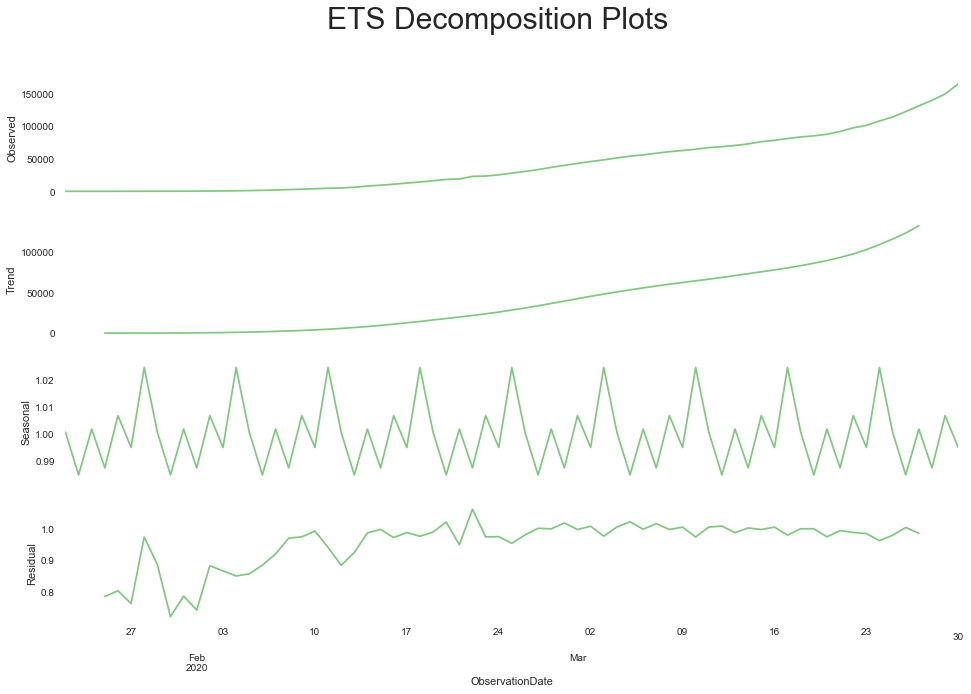

In [11]:
time_series.decomposition_plot(df,'Recovered','multiplicative')

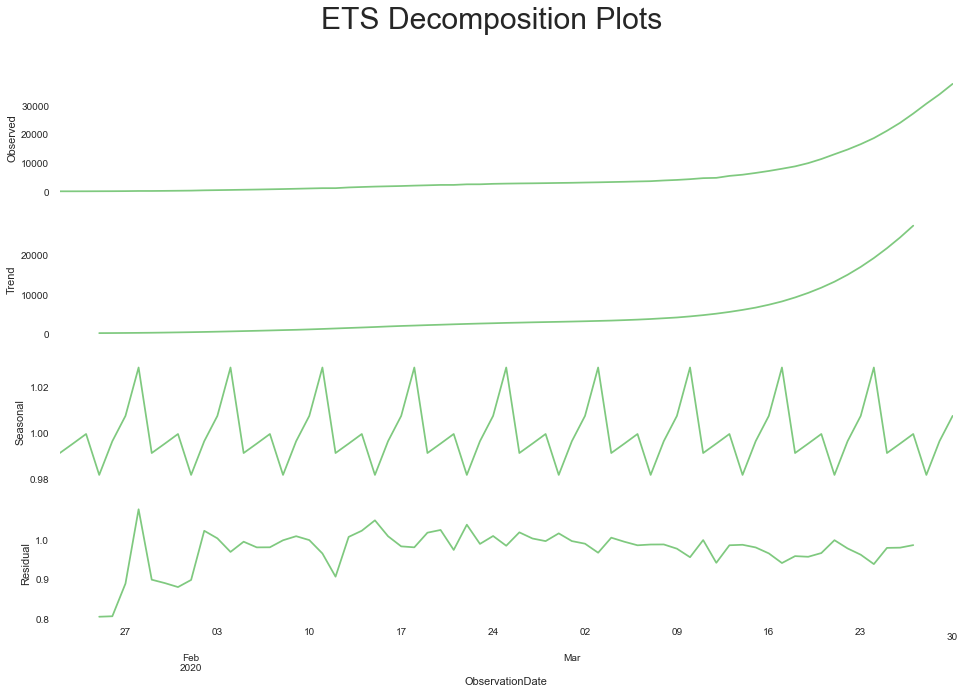

In [12]:
time_series.decomposition_plot(df,'Deaths','multiplicative')

Grafik diatas menjelaskan trend, seasonal, dan residual yang ada pada data. 

`TREND`
nampak pada data awal terlihat seluruh data (Confirmed,Recovered, Deaths) terdeteksi trend yang meningkat seiring dengan peningkatan waktu.

`Seasonal`
nampak pada seluruh data adanya model seasonal untuk sesuai dengan siklus 7 hari dengan puncak berada pada weekend. (data sekitar 69 hari sehingga akan ada 10 puncak)
hal ini dapat dijelaskan bahwa penyebaran virus semakin besar dengan mengikuti hari kerja (dimana pada confirmed terdeteksi 2 puncak di weekend dan 2-3 hari setelah weekend dimana penderita baru meresakan setelah sekitar 2-3 hari kemudian). atau ada kemungkinan pengecekan berkala berlangsung selama 7 harian. Namun dengan tingkat sesionalnya yang rendah perlu ada tinjauan lebih mendalam untuk hal ini.

## Run ADF test to check if data is stationary 

In [13]:
adf_result,adf = time_series.adf_test(df,'Confirmed')

Augmented Dickey-Fuller Test:
p-val of the ADF test in dataset: 0.9988876652423764
Augmented Dickey-Fuller Test on Sales Data

ADF test statistic       2.206320
p-value                  0.998888
#lags used               1.000000
#observations           67.000000
critical value (1%)     -3.531955
critical value (5%)     -2.905755
critical value (10%)    -2.590357
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [14]:
adf_result,adf = time_series.adf_test(df,'Recovered')

Augmented Dickey-Fuller Test:
p-val of the ADF test in dataset: 0.9989738060209037
Augmented Dickey-Fuller Test on Sales Data

ADF test statistic       2.330591
p-value                  0.998974
#lags used              11.000000
#observations           57.000000
critical value (1%)     -3.550670
critical value (5%)     -2.913766
critical value (10%)    -2.594624
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [15]:
adf_result,adf = time_series.adf_test(df,'Deaths')

Augmented Dickey-Fuller Test:
p-val of the ADF test in dataset: 0.9990540883901355
Augmented Dickey-Fuller Test on Sales Data

ADF test statistic       2.513545
p-value                  0.999054
#lags used              10.000000
#observations           58.000000
critical value (1%)     -3.548494
critical value (5%)     -2.912837
critical value (10%)    -2.594129
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


pada bagian ini kita uji data tersebut apakah terdapat model stationary didalamnya atau tidak.
didapat tidak stationary dan dianggap perlu prediksi selain prediksi time series yang mampu melakukan prediksi yang dibutuhkan.

# Modeling

Teknik yang akan digunakan adalah model kompartemen yang biasanya digunakan untuk memodelkan penyakit menular.
Hal yang sama juga dapat digunakan dalam kasus COVID-19. 
Model kompartemen paling sederhana adalah model SIR.

Model terdiri dari tiga kompartemen: S untuk jumlah rentan, I untuk jumlah infeksius, dan R untuk jumlah individu yang pulih atau meninggal (atau kebal). 
Model ini cukup dapat memprediksi penyakit menular yang ditularkan dari manusia ke manusia, dan di mana pemulihan memberikan ketahanan yang tetap, seperti campak, gondok, dan rubella. 

## SIR model

In [109]:
class Learner(object):
    def __init__(self,df, loss, start_date, predict_range, s_0, i_0, r_0):
        self.df = df
        self.loss = loss
        self.start_date = start_date
        self.predict_range = predict_range
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0

    def extend_index(self, index, new_size):
        values = index.values
        current = index[-1]
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, current)
        return values

    def predict(self, beta, gamma, data, recovered, death, s_0, i_0, r_0):
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
        extended_death = np.concatenate((death.values, [None] * (size - len(death.values))))
        return new_index, extended_actual, extended_recovered, extended_death, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))


    def train(self):
        recovered = self.df["Recovered"]
        death = self.df["Deaths"]
        data = self.df['Confirmed']
    
        optimal = minimize(loss, [0.00000233, 0.01854502], args=(data, recovered, self.s_0, self.i_0, self.r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
        print(optimal)
        beta, gamma = optimal.x
#         beta= 0.0000233
#         gamma=0.1854502
        new_index, extended_actual, extended_recovered, extended_death, prediction = self.predict(beta, gamma, data, recovered, death, self.s_0, self.i_0, self.r_0)
        df = pd.DataFrame({'Infected data': extended_actual, 'Recovered data': extended_recovered, 'Death data': extended_death, 'Susceptible': prediction.y[0], 'Infected': prediction.y[1], 'Recovered': prediction.y[2]}, index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title('prediksi covid 19')
        df.plot(ax=ax)
        print(f" beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
        fig.savefig(f"predict.png")
        #return recovered, death, data, conf


In [110]:
def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

      fun: 60382.71437168963
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([5.70634594e+10, 6.08919153e+07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 24
      nit: 2
     njev: 8
   status: 0
  success: True
        x: array([2.05137268e-07, 1.00000000e-08])
 beta=0.00000021, gamma=0.00000001, r_0:20.51372683


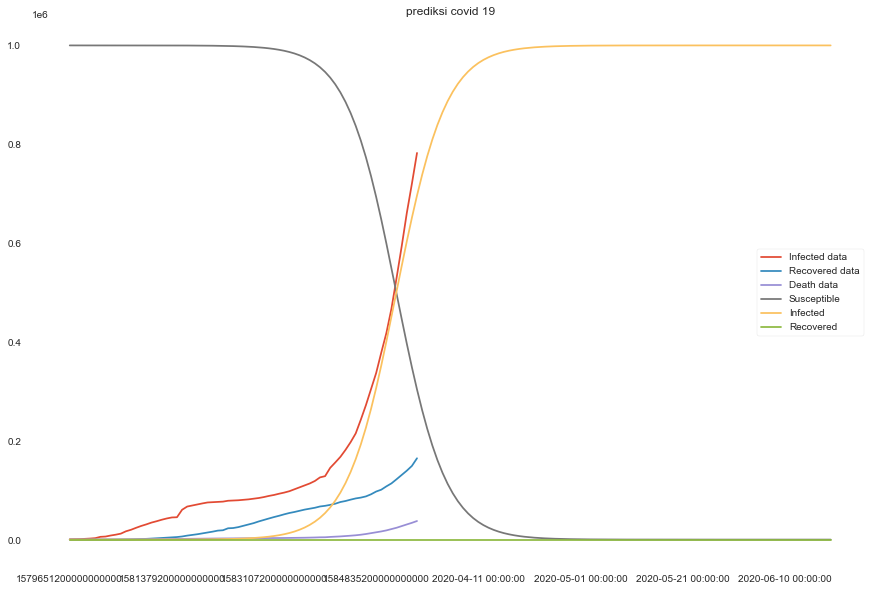

In [111]:
learner = Learner(df,loss=loss, start_date="2020-01-23", predict_range=150,s_0=1000000, i_0=2, r_0=0)
#try:
learner.train()

# Machine learning

In [258]:
#future forcasting for the next 10 days
dates = df['Confirmed'].keys()

days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
total_confirmed = np.array(df['Confirmed']).reshape(-1, 1)
total_deaths = np.array(df['Deaths']).reshape(-1, 1)
total_recovered = np.array(df['Recovered']).reshape(-1, 1)

days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1,1)
adjusted_dates = future_forcast[:-10]

In [259]:
start = '1/22/2020'
start_date = datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + timedelta(days=i)).strftime('%m/%d/%Y'))

In [261]:
#split in to train test data
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, total_confirmed, test_size=0.15, shuffle=False) 

In [157]:
#split in to train test data
X_train_death, X_test_death, y_train_death, y_test_death = train_test_split(days_since_1_22, total_deaths, test_size=0.15, shuffle=False) 

In [158]:
#split in to train test data
X_train_recovered, X_test_recovered, y_train_recovered, y_test_recovered = train_test_split(days_since_1_22, total_recovered, test_size=0.15, shuffle=False) 

## Predict confirmed using Support Vector Machine

In [262]:
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=7, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred_confirmed = svm_confirmed.predict(future_forcast)

## baseline prediction with linier regression

In [263]:
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(X_test_confirmed)
linear_pred = linear_model.predict(future_forcast)

## testing / evaluation

SVM prediction
RMAE: 262.1400216258653
RMSE: 80522.33805848338
Linier prediction
MAE: 569.0965890414901
MSE: 360046.5012385194


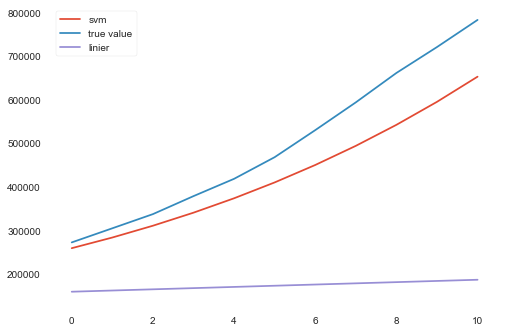

In [264]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
test_linear_pred = linear_model.predict(X_test_confirmed)
plt.plot(svm_test_pred,label='svm')
plt.plot(y_test_confirmed,label='true value')
plt.plot(test_linear_pred,label='linier')
plt.legend()
print('SVM prediction')
print('RMAE:', mean_absolute_error(svm_test_pred, y_test_confirmed)**0.5)
print('RMSE:',mean_squared_error(svm_test_pred, y_test_confirmed)**0.5)
print('Linier prediction')
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed)**0.5)
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed)**0.5)

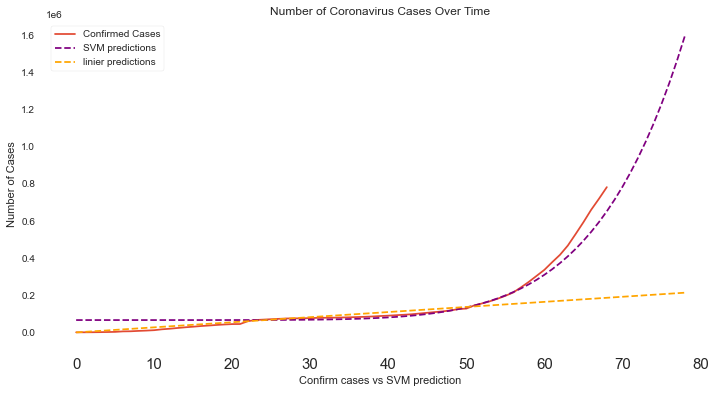

In [265]:
plt.figure(figsize=(12, 6))
plt.plot(adjusted_dates, total_confirmed)
plt.plot(future_forcast, svm_pred_confirmed, linestyle='dashed', color='purple')
plt.plot(future_forcast, linear_pred, linestyle='dashed', color='orange')
plt.title('Number of Coronavirus Cases Over Time')
plt.xlabel('Confirm cases vs SVM prediction')
plt.ylabel('Number of Cases')
plt.legend(['Confirmed Cases', 'SVM predictions',"linier predictions"])
plt.xticks(size=15)
plt.show()

In [228]:
print('SVM future confirmed predictions for 10 Days:')
set(zip(future_forcast_dates[-10:], svm_pred_confirmed[-10:]))

SVM future confirmed predictions for 10 Days:


{('03/31/2020', 715190.4391746216),
 ('04/01/2020', 783921.4985446625),
 ('04/02/2020', 858803.2074432068),
 ('04/03/2020', 940287.5681724243),
 ('04/04/2020', 1028852.7753371887),
 ('04/05/2020', 1125004.3380164795),
 ('04/06/2020', 1229276.2338866882),
 ('04/07/2020', 1342232.0946998291),
 ('04/08/2020', 1464466.4251632385),
 ('04/09/2020', 1596605.853546112)}

## Predict death using Support Vector Machine

In [229]:
svm_death = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=7, C=0.001)
svm_death.fit(X_train_death, y_train_death)
svm_pred_death = svm_death.predict(future_forcast)

## baseline prediction with linier regression

In [230]:
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(X_train_death, y_train_death)
test_linear_pred = linear_model.predict(X_test_death)
linear_pred = linear_model.predict(future_forcast)

# testing / evaluation

SVM prediction
RMAE: 60.4120824776659
RMSE: 4382.526601092833
Linier prediction
MAE: 128.46140166925466
MSE: 18390.408617045156


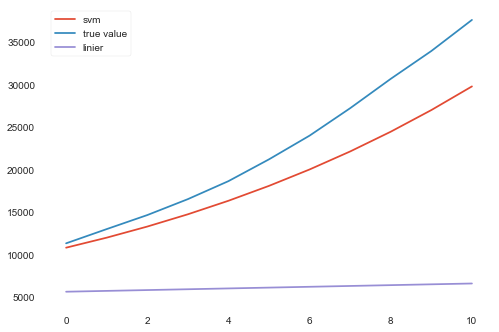

In [232]:
# check against testing data
svm_test_pred = svm_death.predict(X_test_death)
test_linear_pred = linear_model.predict(X_test_death)
plt.plot(svm_test_pred,label='svm')
plt.plot(y_test_death,label='true value')
plt.plot(test_linear_pred,label='linier')
plt.legend()
print('SVM prediction')
print('RMAE:', mean_absolute_error(svm_test_pred, y_test_death)**0.5)
print('RMSE:',mean_squared_error(svm_test_pred, y_test_death)**0.5)
print('Linier prediction')
print('MAE:', mean_absolute_error(test_linear_pred, y_test_death)**0.5)
print('MSE:',mean_squared_error(test_linear_pred, y_test_death)**0.5)

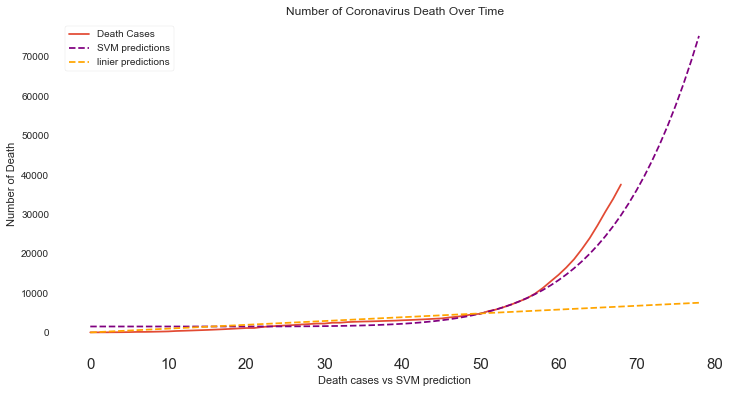

In [233]:
plt.figure(figsize=(12, 6))
plt.plot(adjusted_dates, total_deaths)
plt.plot(future_forcast, svm_pred_death, linestyle='dashed', color='purple')
plt.plot(future_forcast, linear_pred, linestyle='dashed', color='orange')
plt.title('Number of Coronavirus Death Over Time')
plt.xlabel('Death cases vs SVM prediction')
plt.ylabel('Number of Death')
plt.legend(['Death Cases', 'SVM predictions',"linier predictions"])
plt.xticks(size=15)
plt.show()

In [234]:
print('SVM future Death predictions for 10 Days:')
set(zip(future_forcast_dates[-10:], svm_pred_death[-10:]))

SVM future Death predictions for 10 Days:


{('03/31/2020', 32799.17882870905),
 ('04/01/2020', 36115.0814604687),
 ('04/02/2020', 39727.71973421447),
 ('04/03/2020', 43658.900319509434),
 ('04/04/2020', 47931.693524651455),
 ('04/05/2020', 52570.48743765824),
 ('04/06/2020', 57601.043594978975),
 ('04/07/2020', 63050.554191135096),
 ('04/08/2020', 68947.70086171501),
 ('04/09/2020', 75322.71504642838)}

## Predict Recovered using Support Vector Machine

In [248]:
svm_recovered = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=7, C=0.01)
svm_recovered.fit(X_train_recovered, y_train_recovered)
svm_pred_recovered = svm_recovered.predict(future_forcast)

## baseline prediction with linier regression

In [249]:
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(X_train_recovered, y_train_recovered)
test_linear_pred = linear_model.predict(X_test_recovered)
linear_pred = linear_model.predict(future_forcast)

## testing / evaluation

SVM prediction
RMAE: 355.99293545446596
RMSE: 139160.4039434093
Linier prediction
MAE: 216.8224168065491
MSE: 51207.90391869273


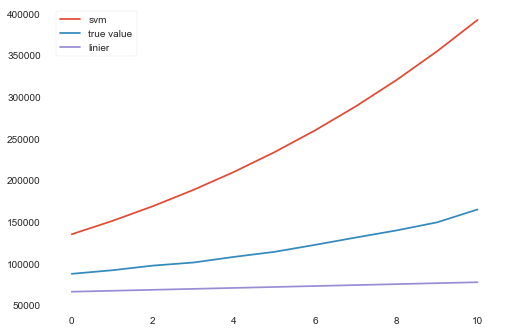

In [251]:
# check against testing data
svm_test_pred = svm_recovered.predict(X_test_recovered)
test_linear_pred = linear_model.predict(X_test_recovered)
plt.plot(svm_test_pred,label='svm')
plt.plot(y_test_recovered,label='true value')
plt.plot(test_linear_pred,label='linier')
plt.legend()
print('SVM prediction')
print('RMAE:', mean_absolute_error(svm_test_pred, y_test_recovered)**0.5)
print('RMSE:',mean_squared_error(svm_test_pred, y_test_recovered)**0.5)
print('Linier prediction')
print('MAE:', mean_absolute_error(test_linear_pred, y_test_recovered)**0.5)
print('MSE:',mean_squared_error(test_linear_pred, y_test_recovered)**0.5)

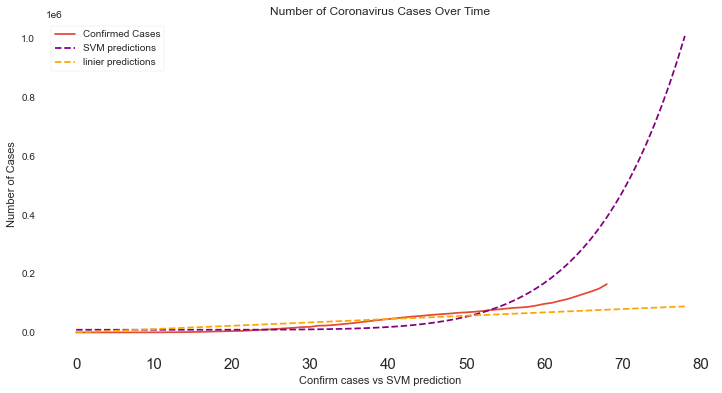

In [253]:
plt.figure(figsize=(12, 6))
plt.plot(adjusted_dates, total_recovered)
plt.plot(future_forcast, svm_pred_recovered, linestyle='dashed', color='purple')
plt.plot(future_forcast, svm_pred_death, linestyle='dashed', color='purple')
plt.plot(future_forcast, linear_pred, linestyle='dashed', color='orange')
plt.title('Number of Coronavirus Cases Over Time')
plt.xlabel('Confirm cases vs SVM prediction')
plt.ylabel('Number of Cases')
plt.legend(['Confirmed Cases', 'SVM predictions',"linier predictions"])
plt.xticks(size=15)
plt.show()

In [254]:
print('SVM future Death predictions for 10 Days:')
set(zip(future_forcast_dates[-10:], svm_pred_recovered[-10:]))

SVM future Death predictions for 10 Days:


{('03/31/2020', 433096.8334187529),
 ('04/01/2020', 478023.5358034632),
 ('04/02/2020', 526970.6680275461),
 ('04/03/2020', 580233.6856113932),
 ('04/04/2020', 638125.1649469397),
 ('04/05/2020', 700975.5368412993),
 ('04/06/2020', 769133.8407496474),
 ('04/07/2020', 842968.4999369642),
 ('04/08/2020', 922868.1178697607),
 ('04/09/2020', 1009242.2961296103)}

# Final plot

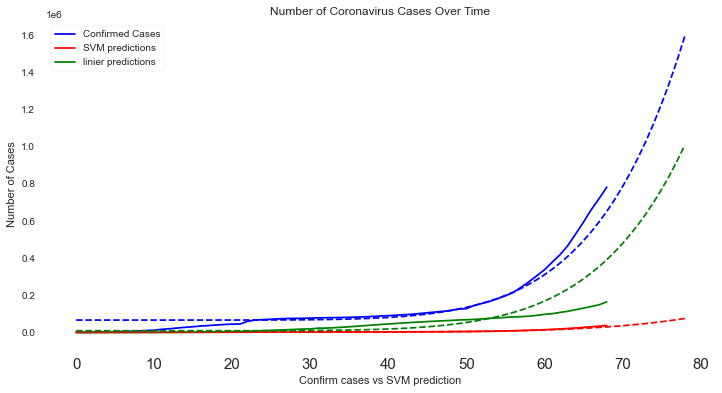

In [267]:
plt.figure(figsize=(12, 6))
plt.plot(adjusted_dates, total_confirmed, color='blue')
plt.plot(adjusted_dates, total_deaths, color='red')
plt.plot(adjusted_dates, total_recovered, color='green')
plt.plot(future_forcast, svm_pred_confirmed, linestyle='dashed', color='blue')
plt.plot(future_forcast, svm_pred_death, linestyle='dashed', color='red')
plt.plot(future_forcast, svm_pred_recovered, linestyle='dashed', color='green')
plt.title('Number of Coronavirus Cases Over Time')
plt.xlabel('Confirm cases vs SVM prediction')
plt.ylabel('Number of Cases')
plt.legend(['Confirmed Cases', 'SVM predictions',"linier predictions"])
plt.xticks(size=15)
plt.show()

# Next plan

jika terdapat data yang lain yang mendukung improvisasi prediksi seperti:

1. data lokasi
2. data jumlah populasi
3. data penyebaran covid

akan sangat membantu dalam prediksi yang confirmed, deaths, and recovery dari covid ini. dimana pada prediksi ini ada kemungkinan valid pada kondisi khusus dan belum merepresentasikan nilai sesungguhnya dari kenyataan dikarenakan informasi yang ada belum mencukupi.